In [1]:
import numpy as np
import os
import torch
import torch.optim as optim
import torch.nn as nn

import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
from loss import *

In [3]:
import paths
import config
import util
import importlib
import data
import decay
import s2s_controller
import trainer, trainer_with_tensorboar, trainer_with_tensorboar_inference
import char_language_model

In [4]:
reload_packages = [paths, util, config, data, decay, s2s_controller, trainer, trainer_with_tensorboar, trainer_with_tensorboar_inference, char_language_model]
for package in reload_packages:
    importlib.reload(package)
# importlib.reload(data)

In [5]:
from tensorboardX import SummaryWriter

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

# Load Data

In [7]:
data_helper = data.Data()

In [8]:
train_loader = data_helper.get_loader(mode='train')
val_loader = data_helper.get_loader(mode='val')
test_loader = data_helper.get_loader(mode='test')

Batch Size:  64
Preparing corpus...
(24724,) (24724,)
Dataset Device: cuda
Batch Size:  64
Preparing corpus...
(1106,) (1106,)
Dataset Device: cuda
Batch Size:  64
Dataset Device: cuda


- [ ] debug loss while validation
    - why loss is so large for almost the same prediction
- [x] add teacher force decay
- [x] add grumbel lr decay
- [x] try to predict using early models
- [ ] TODO: in random search inferensing, use a batch of same utterance of size NUM_CANDIDATE instead of looping.
- [ ] weight initialization according to the paper
- [ ] init bias with tf
- [ ] pretrain word embedding

# Define model

In [9]:
data_helper.LANG.n_chars

34

In [10]:
parameters = {
    'embed_size' : 40, 
    'hidden_size' : 256, 
    'n_layers' : 1, # number of hidden layers in the first lstm layer
    'n_plstm'  : 3, # one normal lstm, three plstm
    'mlp_hidden_size' : 128,
    'mlp_output_size' : 128,
    # ---- decoder ----
    'decoder_vocab_size' : data_helper.LANG.n_chars, 
    'decoder_embed_size' : 256, 
    'decoder_hidden_size' : 512, 
    'decoder_n_layers' : 2, 
    'decoder_mlp_hidden_size' : 256,
    'decoder_padding_value' : char_language_model.EOS_token,
    'GUMBEL_SOFTMAX' :False,
    'batch_size' : 64, 
    'INIT_STATE' : False
}
# use eos token to pad
# use the vocab_size as the padding value for label embedding and pad_sequence; 
# cannot use -1 for label, which will cause error in criterion

In [11]:
model = s2s_controller.Sequence2Sequence(**parameters) 

In [12]:
model

Sequence2Sequence(
  (encoder): Encoder_RNN(
    (rnns): ModuleList(
      (0): LSTM(40, 256, bidirectional=True)
      (1): pBLSTM(
        (lstm): LSTM(1024, 256, bidirectional=True)
        (locked_dropout): LockedDropout()
      )
      (2): pBLSTM(
        (lstm): LSTM(1024, 256, bidirectional=True)
        (locked_dropout): LockedDropout()
      )
      (3): pBLSTM(
        (lstm): LSTM(1024, 256, bidirectional=True)
        (locked_dropout): LockedDropout()
      )
    )
    (fc1): Linear(in_features=512, out_features=128, bias=True)
    (fc2): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): Decoder_RNN(
    (embedding): Embedding(34, 256)
    (rnns): ModuleList(
      (0): LSTMCell(384, 512)
      (1): LSTMCell(512, 512)
    )
    (attention): Attention()
    (fc): Linear(in_features=512, out_features=128, bias=True)
    (mlp): MLP(
      (fc1): Linear(in_features=256, out_features=256, bias=True)
      (relu): LeakyReLU(negative_slope=0.5)
      (fc2): Li

In [13]:
# initialize the bias of the last linear layer with char prob distribution
model.state_dict().keys()

char_distribution = {i: data_helper.LANG.char2count[i]/sum(data_helper.LANG.char2count.values()) for i in data_helper.LANG.char2count}

decoder_fc2_bias = [np.mean(list(char_distribution.values())), np.mean(list(char_distribution.values()))]

decoder_fc2_bias

decoder_fc2_bias = decoder_fc2_bias + [char_distribution[data_helper.LANG.index2char[i]] for i in range(34) if i not in [0,1]]

len(decoder_fc2_bias)

model.decoder.mlp.fc2.bias = torch.nn.Parameter(torch.tensor(decoder_fc2_bias))
# tie two layers again
model.decoder.embedding.bias = model.decoder.mlp.fc2.bias

In [14]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3*0.5, momentum=0.9, nesterov=True)
best_epoch, best_vali_loss, starting_epoch = 0, 400, 0

In [15]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

In [16]:
criterion = nn.CrossEntropyLoss(reduction='none')
# criterion = loss.SoftCrossEntropy(reduction='none') # training uses gumbel softmax smoothed ground truth to calculate loss
validation_criterion = nn.CrossEntropyLoss(reduction='none') # validation uses hard label ground truth to calculate loss

In [17]:
output_path = os.path.join(paths.output_path, 'experiment_baseline_outputs')

In [18]:
# # proceeding from old models
# model_path = os.path.join(output_path, 'baseline_s2s_19.pth.tar')
# print("=> loading checkpoint '{}'".format(model_path))
# checkpoint = torch.load(model_path)
# starting_epoch = checkpoint['epoch']+1
# # best_vali_acc = checkpoint['best_vali_acc']
# model_state_dict = checkpoint['model_state_dict']
# model.load_state_dict(model_state_dict)
# optimizer.load_state_dict(checkpoint['optimizer_label_state_dict'])
# best_vali_loss = checkpoint['best_vali_loss']
# best_epoch = checkpoint['best_epoch']
# print("=> loaded checkpoint '{}' (epoch {})"
#       .format(model_path, checkpoint['epoch']))
# # del checkpoint, model_state_dict

In [19]:
# for state in optimizer.state.values():
#     for k, v in state.items():
#         if isinstance(v, torch.Tensor):
#             state[k] = v.cuda()

In [20]:
init_TEACHER_FORCING_Ratio=0.9
decay_scheduler = decay.BasicDecay(initial_rate=init_TEACHER_FORCING_Ratio, anneal_rate=0.9, min_rate=0.6, every_step=5, mode='step')

for i in range(20):
    print(decay_scheduler.get_rate(i))

0.9
0.9
0.9
0.9
0.9
0.81
0.81
0.81
0.81
0.81
0.7290000000000001
0.7290000000000001
0.7290000000000001
0.7290000000000001
0.7290000000000001
0.6561000000000001
0.6561000000000001
0.6561000000000001
0.6561000000000001
0.6561000000000001


In [21]:
# %pdb
with SummaryWriter(os.path.join(output_path, "tensorboard_logs/train_pytorch"), comment='training') as tLog, SummaryWriter(os.path.join(output_path, "tensorboard_logs/val_pytorch"), comment='testing') as vLog: 
#     tLog.add_graph(model, test_input, True)
    trainer_with_tensorboar_inference.run(model = model,
                                optimizer = optimizer,
                                criterion = criterion,
                                validation_criterion = validation_criterion,
                                train_dataloader = train_loader,
                                valid_dataloader = val_loader,
                                language_model = data_helper.LANG,
                                best_epoch = best_epoch,
                                best_vali_loss = best_vali_loss, 
                                DEVICE = DEVICE, 
                                tLog = tLog,
                                vLog = vLog,
                                teacher_forcing_scheduler = decay_scheduler,
                                scheduler=scheduler, 
                                start_epoch=starting_epoch, 
                                model_prefix=config.model_prefix,
                                output_path=output_path)

-- Starting training with scheduler.
### Epoch     0 
Pred:                                                                                                                                                                                            , True: JAPANESE BANKS' SECURITIES SUBSIDIARIES TYPICALLY HAVE ASSETS OF BETWEEN THREE HUNDRED MILLION POUNDS TO FIVE HUNDRED MILLION POUNDS ACCORDING TO A BANK OF ENGLAND SURVEY
Pred: T       N   OENEN   OONEE EN  REN OON TT   OE  TO TENE TEENEE REN  OE N E   TON EN  OON  NTEN   TE TE   OON N   OON E TON EN TN NTE  ONEE   O  ON   EEN OON E TOE   TON       TN  ONN     TNEN OENN ON  NE N   OO  NN , True: YESTERDAY'S DIVIDEND ACTIVITY WAS CONCENTRATED IN FIVE STOCKS DASH SOUTHERN COMPANY COMMA PINNACLE WEST CAPITAL COMMA CINCINNATI GAS AMPERSAND ELECTRIC COMMA CHASE MANHATTAN AND EASTERN UTILITIES ASSOCIATES PERIOD
Epoch: 0	Batch: 100	Avg-Loss: 299.9601	Avg-Perplexity: 18.5527	Avg-Distance: 175.3877 
Pred: TERNE  TORNE TN   TORN  TOEMEENT N N  T

KeyboardInterrupt: 

In [22]:
# %pdb
# trainer.run(model = model,
#             optimizer = optimizer, 
#             criterion = criterion, 
#             train_dataloader = train_loader, 
#             valid_dataloader = val_loader, 
#             language_model = data_helper.LANG,
#             best_epoch = best_epoch, 
#             best_vali_loss = best_vali_loss, 
#             DEVICE = DEVICE, 
#             TEACHER_FORCING_Ratio = 1,
#             scheduler=None, 
#             start_epoch=starting_epoch, 
#             model_prefix=config.model_prefix)

# Validation

In [23]:
# %pdb
# model = model.to(DEVICE)
# validation_criterion = validation_criterion.to(DEVICE)
# trainer_with_tensorboar_inference.test_validation(model=model,
#                                                   validation_criterion = validation_criterion,
#                                                   valid_dataloader = val_loader, 
#                                                   language_model = data_helper.LANG, 
#                                                   DEVICE = DEVICE)

In [24]:
# %%time
# model = model.to(DEVICE)
# validation_criterion = validation_criterion.to(DEVICE)
# print(trainer_with_tensorboar_inference.test_validation_random_search(model=model,
#                                                                       validation_criterion = validation_criterion,
#                                                                       valid_dataloader = val_loader, 
#                                                                       language_model = data_helper.LANG, 
#                                                                       DEVICE = DEVICE, 
#                                                                       MAX_SEQ_LEN=500, 
#                                                                         N_CANDIDATES=100))

In [25]:
# %%time
# %pdb
# model = model.to(DEVICE)
# validation_criterion = validation_criterion.to(DEVICE)
# print(trainer_with_tensorboar_inference.test_validation_beam_search(model=model,
#                                                                       validation_criterion = validation_criterion,
#                                                                       valid_dataloader = val_loader, 
#                                                                       language_model = data_helper.LANG, 
#                                                                       DEVICE = DEVICE, 
#                                                                       MAX_SEQ_LEN=500, 
#                                                                       beam_size=5, 
#                                                                       num_candidates=1))

Automatic pdb calling has been turned ON


NameError: name 'PROMPT' is not defined

> /home/ubuntu/deep_learning/utterance2text_attention_LAS/trainer_with_tensorboar_inference.py(449)test_validation_beam_search()
    447 
    448 def test_validation_beam_search(model, validation_criterion, valid_dataloader, language_model, DEVICE, MAX_SEQ_LEN=500, beam_size=5, num_candidates=1):
--> 449     if PROMPT:
    450         print('## Start validating....')
    451     model.eval()



ipdb>  q


# Testing

In [24]:
# %pdb
# for epoch in [16,17,18,19,20]:
#     # checkpoint = torch.load("checkpoint.pt")
#     model_prediction = s2s_controller.Sequence2Sequence(**parameters) 
#     # proceeding from old models
#     model_path = os.path.join(output_path, 'baseline_s2s_'+str(epoch)+'.pth.tar')
#     print("=> loading checkpoint '{}'".format(model_path))
#     checkpoint = torch.load(model_path)
#     starting_epoch = checkpoint['epoch']+1
#     model_state_dict = checkpoint['model_state_dict']
#     model_prediction.load_state_dict(model_state_dict)
#     # optimizer.load_state_dict(checkpoint['optimizer_label_state_dict'])
#     best_vali_loss = checkpoint['best_vali_loss']
#     best_epoch = checkpoint['best_epoch']
#     print("=> loaded checkpoint '{}' (epoch {})"
#           .format(model_path, checkpoint['epoch']))

#     print('val_loss:%.4f val_distance:%.4f' % (checkpoint['val_loss'], checkpoint['val_distance']))

#     model_prediction = model_prediction.to(DEVICE)
# #     references = trainer_with_tensorboar_inference.inference(model_prediction, test_loader,language_model=data_helper.LANG, MAX_SEQ_LEN=500)
#     references = trainer_with_tensorboar_inference.inference_random_search(model_prediction, test_loader,language_model=data_helper.LANG, validation_criterion=validation_criterion, DEVICE=DEVICE, MAX_SEQ_LEN=500, N_CANDIDATES=100, GUMBEL_T=1.2)
#     import pandas as pd
#     varification_results_df = pd.DataFrame({'Id':np.arange(test_loader.dataset.size), 'Predicted':np.array(references)})

#     varification_results_df.to_csv(os.path.join(paths.output_path, 'submission_'+'baseline_random_'+str(epoch)+'.csv'),index=False)

In [19]:
# # %pdb
# for epoch in [18,19]:
#     # checkpoint = torch.load("checkpoint.pt")
#     model_prediction = s2s_controller.Sequence2Sequence(**parameters) 
#     # proceeding from old models
#     model_path = os.path.join(output_path, 'backup', 'baseline_s2s_'+str(epoch)+'.pth.tar')
#     print("=> loading checkpoint '{}'".format(model_path))
#     checkpoint = torch.load(model_path)
#     starting_epoch = checkpoint['epoch']+1
#     model_state_dict = checkpoint['model_state_dict']
#     model_prediction.load_state_dict(model_state_dict)
#     # optimizer.load_state_dict(checkpoint['optimizer_label_state_dict'])
#     best_vali_loss = checkpoint['best_vali_loss']
#     best_epoch = checkpoint['best_epoch']
#     print("=> loaded checkpoint '{}' (epoch {})"
#           .format(model_path, checkpoint['epoch']))

#     print('val_loss:%.4f val_distance:%.4f' % (checkpoint['val_loss'], checkpoint['val_distance']))

#     model_prediction = model_prediction.to(DEVICE)
# #     references = trainer_with_tensorboar_inference.inference(model_prediction, test_loader,language_model=data_helper.LANG, MAX_SEQ_LEN=500)
#     references = trainer_with_tensorboar_inference.inference_beam_search(model_prediction, test_loader,language_model=data_helper.LANG, MAX_SEQ_LEN=500, beam_size=5, num_candidates=1)
#     import pandas as pd
#     varification_results_df = pd.DataFrame({'Id':np.arange(test_loader.dataset.size), 'Predicted':np.array(references)})

#     varification_results_df.to_csv(os.path.join(paths.output_path, 'submission_'+'baseline_beam_'+str(epoch)+'.csv'),index=False)

=> loading checkpoint '../outputs/experiment_baseline_outputs/backup/baseline_s2s_18.pth.tar'
=> loaded checkpoint '../outputs/experiment_baseline_outputs/backup/baseline_s2s_18.pth.tar' (epoch 18)
val_loss:516.0710 val_distance:10.3702
## Start inferencing....


KeyboardInterrupt: 

In [ ]:
# %pdb
# model = model.to(DEVICE)
# references = trainer_with_tensorboar_inference.inference(model, test_loader,language_model=data_helper.LANG, MAX_SEQ_LEN=500)

In [ ]:
# references_random_search = trainer_with_tensorboar_inference.inference(model, test_dataloader, data_helper.LANG, MAX_SEQ_LEN=500, N_CANDIDATES=100)

# Evaluation

In [102]:
# encoder = nn.Sequential(list(model.children())[0]).to(DEVICE)
# decoder = nn.Sequential(list(model.children())[1]).to(DEVICE)

In [103]:
# test = next(iter(train_loader))

In [104]:
# utterance = test[0][0:2]
# # utterance.size()

In [106]:
# utterance[0].size(), utterance[1].size()

(torch.Size([774, 40]), torch.Size([420, 40]))

In [107]:
# transcript = test[1][0:2]
# # transcript.size()
# transcript[0].size(), transcript[1].size()

(torch.Size([146]), torch.Size([69]))

In [108]:
# y_hat_label, labels_padded, attentions, masked_energy, key_mask  = trainer.evaluate(encoder=encoder,
#                                                          decoder=decoder,
#                                                          lang=data_helper.LANG,
#                                                          utterance=utterance,
#                                                          transcript=transcript,
#                                                          TEACHER_FORCING_Ratio=1)

In [148]:
# y_hat_label.size()

torch.Size([2, 146])

In [110]:
# labels_padded.size()

torch.Size([2, 146])

In [111]:
# labels_padded

tensor([[ 0, 22,  7,  9,  2, 10, 21, 20,  7, 26, 15, 21, 20, 25,  2,  7, 24, 11,
          2, 15, 20,  9, 24, 11,  7, 25, 15, 20, 13,  2, 19, 21, 24, 11,  2, 24,
          7, 22, 15, 10, 18, 31,  2, 26, 14,  7, 20,  2, 26, 14, 21, 25, 11,  2,
         12, 24, 21, 19,  2, 15, 20, 10, 15, 28, 15, 10, 27,  7, 18, 25,  2, 19,
          7, 17, 15, 20, 13,  2,  9,  7, 20, 10, 15, 10,  7, 26, 11, 25,  2, 19,
         21, 24, 11,  2, 14, 11,  7, 28, 15, 18, 31,  2, 24, 11, 18, 15,  7, 20,
         26,  2, 21, 20,  2, 25, 22, 11,  9, 15,  7, 18,  2, 15, 20, 26, 11, 24,
         11, 25, 26,  2, 19, 21, 20, 11, 31,  2, 26, 14,  7, 20,  2, 11, 28, 11,
         24,  1],
        [ 0, 10, 21, 27,  8, 18, 11,  5, 23, 27, 21, 26, 11,  2, 29, 11,  2, 18,
         21, 28, 11,  2, 26, 14, 11, 25, 11,  2, 14, 21, 24, 25, 11, 25,  2,  9,
         21, 19, 19,  7,  2, 10, 21, 27,  8, 18, 11,  5, 23, 27, 21, 26, 11,  2,
         14, 11,  2, 25,  7, 31, 25,  2, 22, 11, 24, 15, 21, 10,  1,  1,  1,  1,
          

In [112]:
# attentions.size()

torch.Size([2, 96, 146])

In [113]:
# attentions

tensor([[[0.0104, 0.0104, 0.0104,  ..., 0.0104, 0.0104, 0.0104],
         [0.0104, 0.0104, 0.0104,  ..., 0.0104, 0.0104, 0.0104],
         [0.0104, 0.0104, 0.0104,  ..., 0.0104, 0.0104, 0.0104],
         ...,
         [0.0104, 0.0104, 0.0104,  ..., 0.0104, 0.0104, 0.0104],
         [0.0104, 0.0104, 0.0104,  ..., 0.0104, 0.0104, 0.0104],
         [0.0104, 0.0104, 0.0104,  ..., 0.0104, 0.0104, 0.0104]],

        [[0.0192, 0.0192, 0.0192,  ..., 0.0193, 0.0193, 0.0193],
         [0.0192, 0.0192, 0.0192,  ..., 0.0192, 0.0192, 0.0192],
         [0.0192, 0.0192, 0.0192,  ..., 0.0192, 0.0192, 0.0192],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0')

In [114]:
# masked_energy

tensor([[[0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.0104],
         [0.

In [116]:
# key_mask.size()

torch.Size([2, 96, 146])

In [132]:
# key_mask[1][1,:]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0')

In [137]:
# torch.full((1,10), 3)

tensor([[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]])

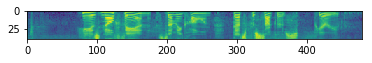

In [50]:
# plt.imshow(utterance.cpu().numpy().T, interpolation='nearest')
# plt.show()

In [51]:
# sentence = data_helper.LANG.indexes2string(labels_padded.cpu().numpy()[0])
# sentence

"HE IS NO FAN SEMI-COLON THAT'S FOR SUCKERS PERIOD"

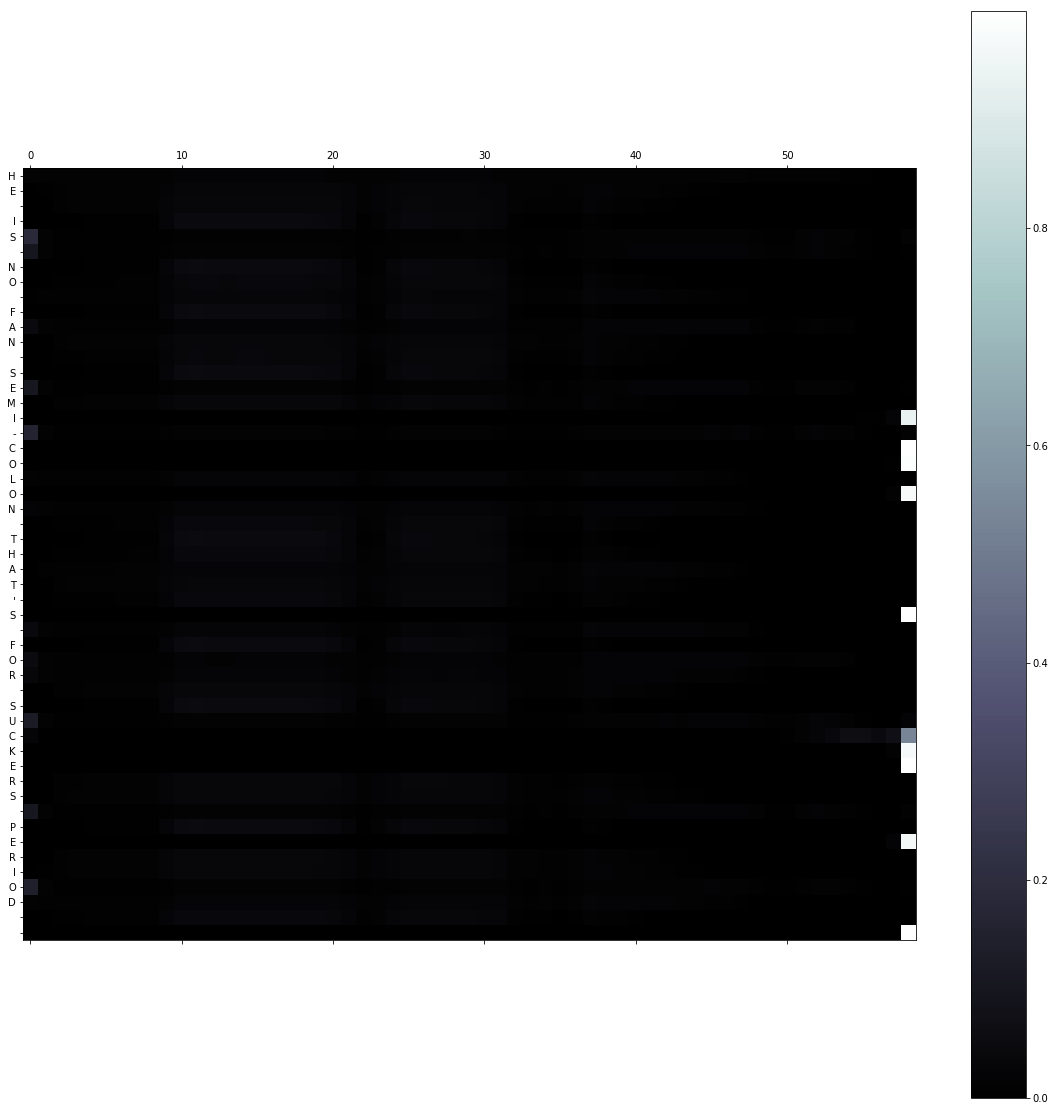

In [52]:
# trainer.showAttention(list(sentence), attentions.squeeze(0).cpu().numpy().T)

In [55]:
# # testing gumbel
# test = torch.randint(0,10,(2,4))
# torch.FloatTensor(test.size()).uniform_(0,1)

# test = nn.Embedding(3,3)

# test(torch.LongTensor([0]))

# batch_size = 5
# length_padded = 10
# nb_digits = 10

# y = torch.LongTensor(length_padded,batch_size, 1).random_() % nb_digits

# # One hot encoding buffer that you create out of the loop and just keep reusing
# y_onehot = torch.FloatTensor(length_padded,batch_size, nb_digits)

# # In your for loop
# y_onehot.zero_()
# y_onehot.scatter_(2, y, 1)

# print(y)
# print(y_onehot)

# class Gumbel_Softmax(nn.Module):
#     """Gumbel_Softmax [Gumbel-Max trick (Gumbel, 1954; Maddison et al., 2014) + Softmax (Jang, E., Gu, S., & Poole, B., 2016)]
#         source: https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb
#     """
#     def __init__(self):
#         super(Gumbel_Softmax, self).__init__()
    
#     def sample_gumbel_distribution(self, size, eps=1e-20):
#         """sample from Gumbel Distribution (0,1)"""
#         uniform_samples = torch.FloatTensor(size).uniform_(0, 1)
#         return -torch.log(-torch.log(uniform_samples + eps) + eps)

#     def forward(self, logits, temperature):
#         y = logits + self.sample_gumbel_distribution(logits.size(), eps=1e-20)
#         return nn.functional.softmax(y/temperature, dim=-1)

# test_gumbel = Gumbel_Softmax()

# test = test_gumbel(y_onehot, 1)

# y_onehot[0,0,:]